In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
import warnings
# We silence warnings concerning future version updates
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# Load training and testing data
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:, 1]

In [3]:
# Arrange answer in two columns. First column (with header "Id") is an
# enumeration from 0 to n-1, where n is the number of test points. Second
# column (with header "EpiOrStroma" is the predictions.
def saveFile(y_pred,name):
    test_header = "Id,EpiOrStroma"
    n_points = X_test.shape[0]
    y_pred_pp = np.ones((n_points, 2))
    y_pred_pp[:, 0] = range(n_points)
    y_pred_pp[:, 1] = y_pred
    np.savetxt(name, y_pred_pp, fmt='%d', delimiter=",",
               header=test_header, comments="")


# Function used to preprocess the data with the Standard Scaler
def scalingFunction(X_train,X_test):
    sc = StandardScaler()

    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.fit_transform(X_test)
    return(X_train_scaled,X_test_scaled)

# GridSearch function for Logistic Classifier. Parameter Grid refined after testing.
def gridSearch(trainData,y_train):
    
    #Creating the Random Grid
    pipe = Pipeline([('classifier' , LogisticRegression())])

    param_grid = [
        {'classifier' : [LogisticRegression()],
         'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear', 'saga'],
        'classifier__max_iter' : [2,5,10,15,25,50,100,150,200]},
    ]

    clf = GridSearchCV(pipe, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1)
    best_clf = clf.fit(trainData, y_train)

    return(best_clf)

In [4]:
# Feature Selection for most important features

def featSelectERT(X_train,X_test,y_train,numberSelectedFeatures):
    #Method 1: Extremely randomised trees
    model = ExtraTreesClassifier()
    model.fit(X_train,y_train)
    # Selection and sorting of most important features.
    feat_scores = model.feature_importances_
    feat_indexes = np.argsort(feat_scores)
    top_indexes = feat_indexes[:numberSelectedFeatures]
    print("Selected",numberSelectedFeatures,"most important features with Extremely Randomised Trees.")
    # Creating new X_train and X_test sets with selected features
    X_train_M1 = np.empty([len(X_train),len(top_indexes)])
    X_test_M1 = np.empty([len(X_test),len(top_indexes)])
    counter = 0
    for index in top_indexes:
        X_train_M1[:,counter] = X_train[:,index]
        X_test_M1[:,counter] = X_test[:,index]
        counter += 1
    return(X_train_M1,X_test_M1)

def featReducPCA(X_train,X_test,numberSelectedFeatures):
    #Method 2: PCA reduction
    pca = PCA(n_components=numberSelectedFeatures)
    X_train_M2 = pca.fit_transform(X_train)
    X_test_M2 = pca.fit_transform(X_test)
    print("Selected",numberSelectedFeatures,"most important features with PCA.")
    return(X_train_M2,X_test_M2)

def featSelectVariance(X_train,X_test,varThreshold):
    #Method 3: Removing features with a variance lower than the given threshold
    sel = VarianceThreshold(threshold=(varThreshold * (1 - varThreshold)))
    X_train_M3 = sel.fit_transform(X_train)
    X_test_M3 = sel.fit_transform(X_test)
    print("Removed features with variance lower than the",varThreshold,"threshold.")
    return(X_train_M3,X_test_M3)

In [5]:
# Logistic Regression Classifier Implementation
clf = LogisticRegression().fit(X_train, y_train)
print('Parameters currently in use:')
print(clf.get_params())

Parameters currently in use:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [6]:
# Evaluating our model with different feature selection methods, selecting a different number of features.
# We have selected precise numbers of features to match the number selected by threshold values

# Reduced the number of trials for the sake of time. This should only take a few minutes.
featNumbers = [85]#[80,82,85,88,90,92,95,98,100]
threshHoldValues = [0.84] #[0.5,0.81,0.84,0.92,0.95,0.96,0.975,0.9895,0.991]

FeatSelect1=np.zeros((len(featNumbers),2))
FeatSelect2=np.zeros((len(featNumbers),2))
FeatSelect3=np.zeros((len(featNumbers),2))

# We now build our SVC model with all feature selection methods, for various number of features.
# Running GridSearch on all combinations should only take a minute or so.
counter = 0
for featNumb in featNumbers:
    # Selection Method 1
    FeatSelect1[counter,0] = featNumb
    X_train_M1, X_test_M1 = featSelectERT(X_train,X_test,y_train,featNumb)
    X_train_M1, X_test_M1 = scalingFunction(X_train_M1, X_test_M1)
    best_LRC_M1 = gridSearch(X_train_M1,y_train)
    FeatSelect1[counter,1] = best_LRC_M1.score(X_train_M1, y_train)
    
    # Selection Method 2
    FeatSelect2[counter,0] = featNumb
    X_train_M2, X_test_M2 = featReducPCA(X_train,X_test,featNumb)
    X_train_M2, X_test_M2 = scalingFunction(X_train_M2, X_test_M2)
    best_LRC_M2 = gridSearch(X_train_M2,y_train)
    FeatSelect2[counter,1] = best_LRC_M2.score(X_train_M2, y_train)
    
    counter += 1


counter = 0
for THValue in threshHoldValues:
    # Selection Method 3
    X_train_M3, X_test_M3 = featSelectVariance(X_train,X_test,THValue)
    X_train_M3, X_test_M3 = scalingFunction(X_train_M3, X_test_M3)
    # The feature selection method is different so we get the shape to obtain the number of features
    FeatSelect3[counter,0] = X_train_M3.shape[1]
    best_LRC_M3 = gridSearch(X_train_M3,y_train)
    FeatSelect3[counter,1] = best_LRC_M3.score(X_train_M3, y_train)
    
    counter += 1

#print(FeatSelect1)
#print(FeatSelect2)
#print(FeatSelect3)

Selected 85 most important features with Extremely Randomised Trees.
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2209 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 6025 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  1.1min finished
C:\Users\Quentin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Selected 85 most important features with PCA.
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done 1660 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5537 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   37.3s finished
C:\Users\Quentin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Removed features with variance lower than the 0.84 threshold.
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 4180 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   46.4s finished
C:\Users\Quentin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


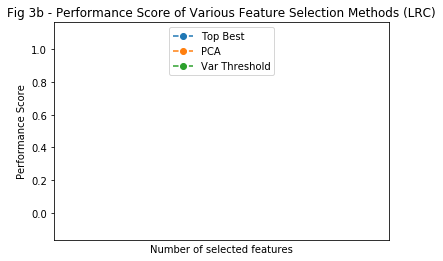

In [11]:
# Graph will display results from previous step (if it was run)
plt.plot(FeatSelect1[:,0],FeatSelect1[:,1],'o--',)
plt.plot(FeatSelect2[:,0],FeatSelect2[:,1],'o--',)
plt.plot(FeatSelect3[:,0],FeatSelect3[:,1],'o--',)

plt.xticks(FeatSelect1[:,0])
plt.legend(["Top Best","PCA","Var Threshold"], loc='upper center')
plt.title("Fig 3b - Performance Score of Various Feature Selection Methods (LRC)")
plt.xlabel("Number of selected features")
plt.ylabel("Performance Score")
plt.show()

In [41]:
# Actual Kaggle scores obtained for testing previously evaluated methods
featNumbersKaggleM1 = [70,80,85,90,100,110]
# Training and testing sets did not always have the same shape given the same threshold
# We have selected values that generate X_train and X_test sets with the same number of features
featNumbersKaggleM3 = [82,87,95,109]

Method1Kaggle = np.zeros((6,2))
Method3Kaggle = np.zeros((4,2))

Method1KaggleScores = [0.88702,0.89558,0.92050,0.89539,0.88702,0.89121]
Method3KaggleScores = [0.83682,0.84100,0.86610,0.86610]


for i in range(6):
    Method1Kaggle[i,0]=featNumbersKaggleM1[i]
    Method1Kaggle[i,1]=Method1KaggleScores[i]
    
    if (i<4):
        Method3Kaggle[i,0]=featNumbersKaggleM3[i]
        Method3Kaggle[i,1]=Method3KaggleScores[i]
    
print(Method1Kaggle)
print(Method3Kaggle)

[[ 70.        0.88702]
 [ 80.        0.89558]
 [ 85.        0.9205 ]
 [ 90.        0.89539]
 [100.        0.88702]
 [110.        0.89121]]
[[ 82.        0.83682]
 [ 87.        0.841  ]
 [ 95.        0.8661 ]
 [109.        0.8661 ]]


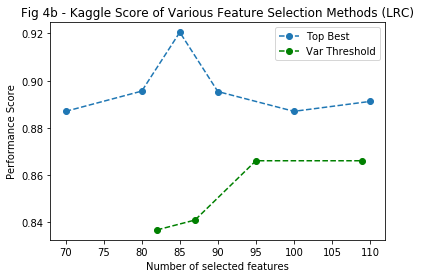

In [51]:
plt.plot(Method1Kaggle[:,0],Method1Kaggle[:,1],'o--',)
plt.plot(Method3Kaggle[:,0],Method3Kaggle[:,1],'o--',color='green')

plt.legend(["Top Best","Var Threshold"], loc='upper right')
plt.title("Fig 4b - Kaggle Score of Various Feature Selection Methods (LRC)")
plt.xlabel("Number of selected features")
plt.ylabel("Performance Score")
plt.show()

In [52]:
# Selection of feature selection method and number based on results - LRC
# This will produce our predictions with the most potential to be submitted (not highest score).
# Top Most Important Features: Selection Method 1 
X_train_final, X_test_final = featSelectERT(X_train,X_test,y_train,85)
X_train_final, X_test_final = scalingFunction(X_train_final, X_test_final)
# The feature selection method is different so we get the shape to obtain the number of features
best_SVC_final = gridSearch(X_train_final,y_train)
print("GridSearch results:",best_SVC_final.best_params_)
print("Shape:",X_train_final.shape)
print("Score:",best_SVC_final.score(X_train_final, y_train))
y_pred_submitted = best_SVC_final.predict(X_test_final)
#saveFile(y_pred_submitted,"finalLRC.csv")

Selected 85 most important features with Extremely Randomised Trees.
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 4915 tasks      | elapsed:   26.8s


GridSearch results: {'classifier': LogisticRegression(C=0.03359818286283781, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.03359818286283781, 'classifier__max_iter': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Shape: (200, 85)
Score: 0.87


[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   50.2s finished
C:\Users\Quentin\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [53]:
# In-Depth Evaluation of most promising combinations for SVC: 
#we need to split the data for further evaluation of our model
X_trainSPLIT, X_testSPLIT, y_trainSPLIT, y_testSPLIT = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

print("training samples: ", len(X_trainSPLIT))
print("testing samples: ", len(X_testSPLIT))

new_X_train, new_X_test = featSelectERT(X_trainSPLIT,X_testSPLIT,y_trainSPLIT,85)
new_X_train, new_X_test = scalingFunction(new_X_train, new_X_test)
LRC_eval = gridSearch(new_X_train,y_trainSPLIT)
print("GridSearch results:",LRC_eval.best_params_)
print("Shape:",new_X_train.shape)
print("Score:",LRC_eval.score(new_X_train, y_trainSPLIT))
y_pred = LRC_eval.predict(new_X_test)
#saveFile(y_pred,"testSVC.csv")

training samples:  160
testing samples:  40
Selected 85 most important features with Extremely Randomised Trees.
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 4472 tasks      | elapsed:   14.9s


GridSearch results: {'classifier': LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.08858667904100823, 'classifier__max_iter': 2, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Shape: (160, 85)
Score: 0.83125


[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   35.1s finished
C:\Users\Quentin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [55]:
# Computing Final Evaluation Metrics for selected Model
print("Accuracy of selected SVC Model:",accuracy_score(y_testSPLIT,y_pred))
print("F1 Score of selected SVC Model:",f1_score(y_testSPLIT,y_pred))
print("Precision of selected SVC Model:",precision_score(y_testSPLIT,y_pred))
print("Recall of selected SVC Model:",recall_score(y_testSPLIT,y_pred))

Accuracy of selected SVC Model: 0.9
F1 Score of selected SVC Model: 0.8749999999999999
Precision of selected SVC Model: 0.8235294117647058
Recall of selected SVC Model: 0.9333333333333333
